Input (300, 1)
  ↓
Conv1D (64 filters, kernel=5, relu) → 특징 추출
  ↓
MaxPooling1D → 차원 축소
  ↓
Dropout(0.3) → 과적합 방지
  ↓
LSTM(64) → 시간 순서 정보 학습
  ↓
Dense(32, relu) → 고수준 특징 처리
  ↓
Dropout(0.2) → 과적합 방지
  ↓
Dense(1, sigmoid) → 부정맥 여부 출력

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, BatchNormalization, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

print(tf.__version__)

2.19.0


In [2]:
# 데이터 로드
normal = np.load('resampled_normal.npy')
abnormal = np.load('resampled_abnormal.npy')

X = np.concatenate([normal, abnormal], axis=0)
y = np.array([0]*len(normal) + [1]*len(abnormal))

X, y = shuffle(X, y, random_state=42)

In [3]:
# 2. 정규화 스케일링 (0~1 범위로)
scaler = MinMaxScaler()
X_scaled = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X])

In [4]:
# 3. 차원 reshape (Conv1D와 LSTM 입력 차원: (samples, timesteps, features))
# (샘플 수, 시간, 채널) 구조
X_scaled = X_scaled.reshape(-1, 100, 1)  # 예: 각 샘플 100길이 신호

In [5]:
# 4. 데이터 분할: 학습용 vs 검증용
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [6]:
# 시계열 기본 통계 분석
def describe_dataset(X, name=""):
    print(f"\n{name} 데이터 통계:")
    print(f"- 샘플 수: {X.shape[0]}")
    print(f"- 시계열 길이: {X.shape[1]}")
    print(f"- 채널 수: {X.shape[2]}")
    print(f"- 전체 값 범위: {X.min():.4f} ~ {X.max():.4f}")
    print(f"- 전체 평균: {X.mean():.4f}")
    print(f"- 전체 표준편차: {X.std():.4f}")

describe_dataset(X_train, "Train")
describe_dataset(X_val, "Validation")



Train 데이터 통계:
- 샘플 수: 5412
- 시계열 길이: 100
- 채널 수: 1
- 전체 값 범위: 0.0000 ~ 1.0000
- 전체 평균: 0.3093
- 전체 표준편차: 0.3005

Validation 데이터 통계:
- 샘플 수: 1354
- 시계열 길이: 100
- 채널 수: 1
- 전체 값 범위: 0.0000 ~ 1.0000
- 전체 평균: 0.3106
- 전체 표준편차: 0.3003


In [7]:
# 5. 모델 설계
model = Sequential([
    # CNN: 주파수 패턴
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(100, 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    # LSTM: 리듬의 순서 정보
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # 이진 분류  # 0 or 1 출력
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\User\anaconda3\envs\ppgd\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# 6. 학습
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6401 - loss: 0.6073 - val_accuracy: 0.9195 - val_loss: 0.2409
Epoch 2/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9137 - loss: 0.2546 - val_accuracy: 0.9431 - val_loss: 0.1681
Epoch 3/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9567 - loss: 0.1538 - val_accuracy: 0.9653 - val_loss: 0.1143
Epoch 4/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9647 - loss: 0.1204 - val_accuracy: 0.9668 - val_loss: 0.1033
Epoch 5/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9683 - loss: 0.1067 - val_accuracy: 0.9697 - val_loss: 0.0992
Epoch 6/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9711 - loss: 0.1034 - val_accuracy: 0.9712 - val_loss: 0.1013
Epoch 7/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9713 - loss: 0.0986 - val_accuracy: 0.9742 - val_loss: 0.0876
Epoch 8/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9759 - loss: 0.0832 - val_accu

In [9]:
# 7. 성능 평가
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9841 - loss: 0.0644
Validation Accuracy: 0.9801


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


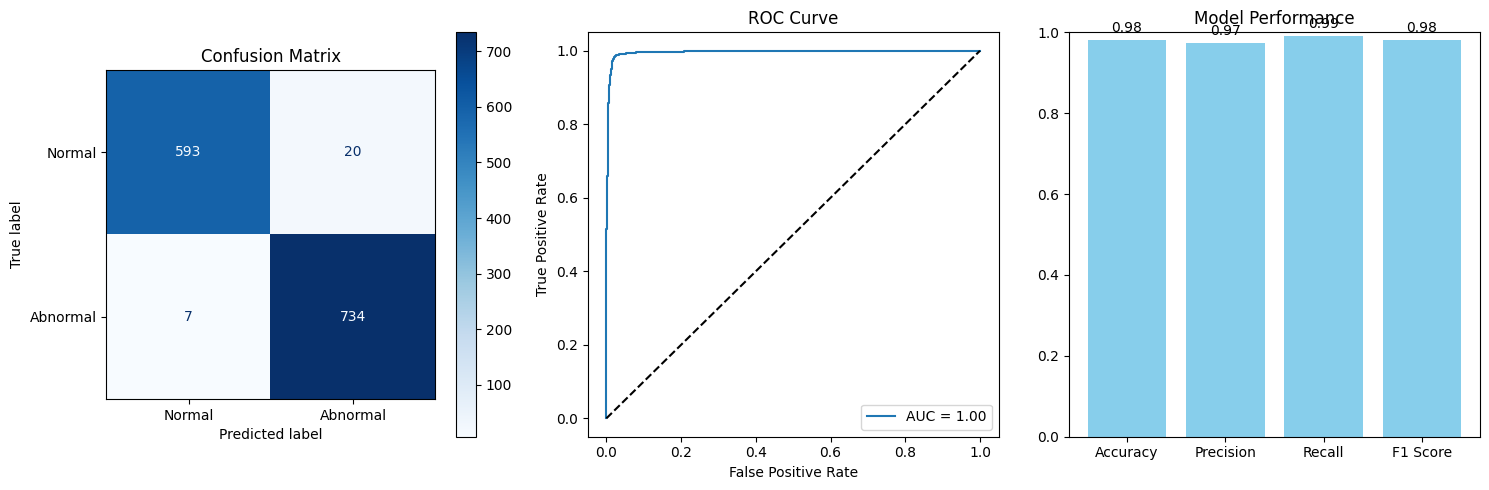

In [10]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
import matplotlib.pyplot as plt

# 예측
y_pred_proba = model.predict(X_val).flatten()
y_pred = (y_pred_proba >= 0.5).astype(int)

# 지표 계산
acc = model.evaluate(X_val, y_val, verbose=0)[1]
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

# 시각화
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(ax=plt.gca(), cmap='Blues')
plt.title("Confusion Matrix")

# ROC Curve
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# 성능 지표 막대그래프
plt.subplot(1, 3, 3)
metrics = [acc, precision, recall, f1]
names = ["Accuracy", "Precision", "Recall", "F1 Score"]
plt.bar(names, metrics, color='skyblue')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.title("Model Performance")

plt.tight_layout()
plt.show()


In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import precision_score


# 1. 데이터 불러오기
test_n = np.load('normal_test_data.npy')      # 정상 샘플
test_abn = np.load('abnormal_test_data.npy')  # 이상 샘플

# 2. X, y 구성
X_test = np.concatenate([test_n, test_abn], axis=0)
y_test = np.array([0]*len(test_n) + [1]*len(test_abn))  # 0: 정상, 1: 이상

# 3. 전처리: 정규화 및 reshape
scaler = MinMaxScaler()
X_test_scaled = np.array([scaler.fit_transform(x.reshape(-1, 1)).flatten() for x in X_test])
X_test_scaled = X_test_scaled.reshape(-1, 100, 1)  # (샘플 수, 길이, 채널)

# 4. 모델 예측
y_pred_prob = model.predict(X_test_scaled)

# 5. 이진화 (0.5 기준으로)
y_pred = (y_pred_prob >= 0.9).astype(int).flatten()

# 6. 평가 지표 계산
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Precision: 0.1822
Recall: 0.9038
F1 Score: 0.3032


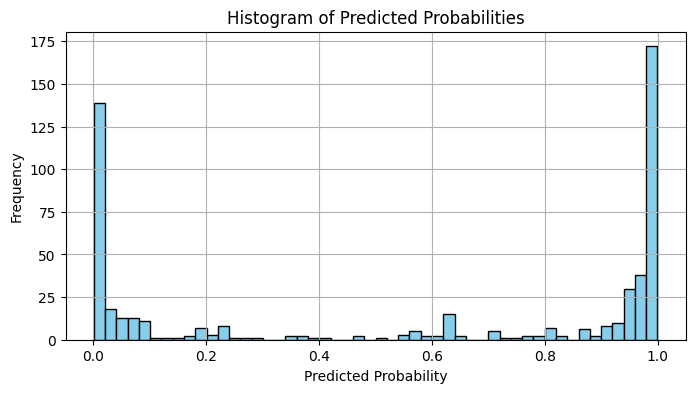

In [12]:
import matplotlib.pyplot as plt

# 전체 y_pred_prob 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(y_pred_prob, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


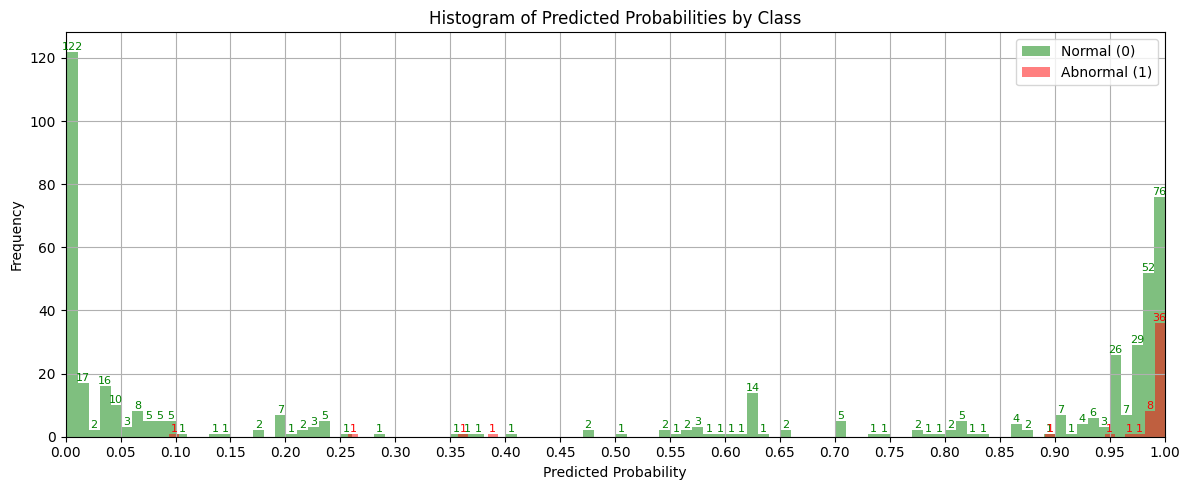

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 히스토그램 직접 변수로 저장 (정상 클래스)
n0, bins0, _ = plt.hist(y_pred_prob[y_test == 0], bins=100, alpha=0.5, label='Normal (0)', color='green')

# 이상 클래스
n1, bins1, _ = plt.hist(y_pred_prob[y_test == 1], bins=100, alpha=0.5, label='Abnormal (1)', color='red')

# 숫자 표기 (빈도 수)
for i in range(len(n0)):
    if n0[i] > 0:
        plt.text((bins0[i] + bins0[i+1]) / 2, n0[i], str(int(n0[i])), ha='center', va='bottom', fontsize=8, color='green')

for i in range(len(n1)):
    if n1[i] > 0:
        plt.text((bins1[i] + bins1[i+1]) / 2, n1[i], str(int(n1[i])), ha='center', va='bottom', fontsize=8, color='red')

# 스타일 및 라벨
plt.title("Histogram of Predicted Probabilities by Class")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 21))  # 0.0 ~ 1.0 사이 눈금

plt.tight_layout()
plt.show()
